In [ ]:
# ⚙️ Gerekli kütüphaneler
!pip install tensorflow matplotlib pandas tqdm --quiet

# 🔹 İçe aktarmalar
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

print("✅ Kütüphaneler başarıyla kuruldu ve içe aktarıldı.")
print(f"TensorFlow versiyonu: {tf.__version__}")
print(f"GPU durumu: {'Kullanılıyor ✅' if tf.config.list_physical_devices('GPU') else 'GPU bulunamadı ⚠️'}")


✅ Kütüphaneler başarıyla kuruldu ve içe aktarıldı.
TensorFlow versiyonu: 2.19.0
GPU durumu: Kullanılıyor ✅


In [ ]:
print("📥 Veri seti indiriliyor...")

path = kagglehub.dataset_download("aryansingh16/deepfake-dataset")

print(f"\n✅ Dataset indirildi: {path}")


📥 Veri seti indiriliyor...
Using Colab cache for faster access to the 'deepfake-dataset' dataset.

✅ Dataset indirildi: /kaggle/input/deepfake-dataset


In [ ]:
import os

base_path = "/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake"

print("📁 Dizin yapısı:")

for root, dirs, files in os.walk(base_path):
    print(f"{root} -> {len(files)} dosya")
    if dirs:
        print("   Alt klasörler:", dirs)


📁 Dizin yapısı:
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake -> 0 dosya
   Alt klasörler: ['valid', 'test', 'train']
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/valid -> 0 dosya
   Alt klasörler: ['fake', 'real']
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/valid/fake -> 10000 dosya
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/valid/real -> 10000 dosya
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test -> 0 dosya
   Alt klasörler: ['fake', 'real']
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/fake -> 10000 dosya
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test/real -> 10000 dosya
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/train -> 0 dosya
   Alt klasörler: ['fake', 'real']
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/train/fake -> 50960 dosya
/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/train/real -> 51081 dosya


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

print("📌 Görseller normalize ediliyor ve veri generator'ları kuruluyor...")

# 0–1 aralığına normalize eden generator
datagen = ImageDataGenerator(rescale=1./255)

train_dir = "/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/train"
valid_dir = "/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/valid"
test_dir  = "/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake/test"

# Eğitim seti
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode="binary",
    shuffle=True
)

# Validasyon seti
valid_gen = datagen.flow_from_directory(
    valid_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode="binary",
    shuffle=True
)

# Test seti
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=64,
    class_mode="binary",
    shuffle=False
)

print("\n✅ Veri generator'ları başarıyla hazırlandı!")


📌 Görseller normalize ediliyor ve veri generator'ları kuruluyor...
Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.

✅ Veri generator'ları başarıyla hazırlandı!


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Görsel boyutu ve latent vektör boyutu
img_shape  = (64, 64, 3)
latent_dim = 100

def build_generator():
    model = models.Sequential(name="LightGAN_G")

    # 100 boyutlu latent vektör
    model.add(layers.Input(shape=(latent_dim,)))

    # 8x8x128’e çık
    model.add(layers.Dense(8 * 8 * 128))
    model.add(layers.Reshape((8, 8, 128)))

    # 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(128, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(64, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(32, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    # Çıkış: 64x64x3, [0,1] aralığı için sigmoid
    model.add(layers.Conv2D(3, 3, padding="same", activation="sigmoid"))

    return model


def build_discriminator():
    model = models.Sequential(name="LightGAN_D")

    model.add(layers.Input(shape=img_shape))

    model.add(layers.Conv2D(64, 3, strides=2, padding="same"))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(128, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(256, 3, strides=2, padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation="sigmoid"))  # gerçek / sahte olasılığı

    return model


generator     = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()


Model: "LightGAN_G"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 8192)           │       827,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_20             │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_58 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_21             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_59 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_22             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_60 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,995 (4.08 MB)

 Trainable params: 1,068,547 (4.08 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "LightGAN_D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_61 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_62 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_63 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,737 (1.48 MB)

 Trainable params: 387,969 (1.48 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
AUTOTUNE   = tf.data.AUTOTUNE
batch_size = train_gen.batch_size  # 64

def gen_to_dataset(gen):
    return tf.data.Dataset.from_generator(
        lambda: gen,
        output_signature=(
            tf.TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,),          dtype=tf.float32),
        )
    )

train_dataset = gen_to_dataset(train_gen).prefetch(AUTOTUNE)


In [ ]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

gen_optimizer  = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]

    # latent vektörlerden sahte görüntü üret
    noise = tf.random.normal(shape=(batch_size, latent_dim))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)

        real_preds = discriminator(real_images, training=True)
        fake_preds = discriminator(fake_images, training=True)

        # Discriminator kaybı (gerçek=1, sahte=0)
        d_loss_real = bce(tf.ones_like(real_preds), real_preds)
        d_loss_fake = bce(tf.zeros_like(fake_preds), fake_preds)
        disc_loss   = (d_loss_real + d_loss_fake) / 2.0

        # Generator kaybı (discriminator sahteyi gerçek sansın)
        gen_loss    = bce(tf.ones_like(fake_preds), fake_preds)

    # Gradientler
    gen_grads  = gen_tape.gradient(gen_loss,  generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads,  generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

EPOCHS          = 10        # istersen 5’e de düşürebilirsin
STEPS_PER_EPOCH = 200       # her epoch'ta 200 batch (~200*64 görüntü)

gen_hist  = []
disc_hist = []

print("\n🚀 LightGAN Eğitimi Başladı...")

for epoch in range(EPOCHS):
    g_total = 0.0
    d_total = 0.0
    steps   = 0

    for real_images, _ in train_dataset.take(STEPS_PER_EPOCH):
        g_loss, d_loss = train_step(real_images)
        g_total += g_loss
        d_total += d_loss
        steps   += 1

    g_avg = g_total / steps
    d_avg = d_total / steps

    gen_hist.append(float(g_avg))
    disc_hist.append(float(d_avg))

    print(f"Epoch {epoch+1}/{EPOCHS} - G Loss: {g_avg:.4f} - D Loss: {d_avg:.4f}")

print("\n✅ Eğitim tamamlandı.")



🚀 LightGAN Eğitimi Başladı...
Epoch 1/10 - G Loss: 2.5001 - D Loss: 0.2060
Epoch 2/10 - G Loss: 1.9993 - D Loss: 0.2873
Epoch 3/10 - G Loss: 2.3819 - D Loss: 0.2274
Epoch 4/10 - G Loss: 2.0679 - D Loss: 0.3355
Epoch 5/10 - G Loss: 1.6905 - D Loss: 0.4079
Epoch 6/10 - G Loss: 1.5179 - D Loss: 0.4608
Epoch 7/10 - G Loss: 1.4959 - D Loss: 0.4850
Epoch 8/10 - G Loss: 1.5115 - D Loss: 0.4850
Epoch 9/10 - G Loss: 1.5372 - D Loss: 0.4660
Epoch 10/10 - G Loss: 1.5810 - D Loss: 0.4616

✅ Eğitim tamamlandı.


In [ ]:
import pandas as pd
import numpy as np

# gen_hist ve disc_hist listelerinin dolu olduğunu varsayıyoruz
epochs_range = np.arange(1, len(gen_hist) + 1)

results_df = pd.DataFrame({
    "Epoch": epochs_range,
    "Generator Loss": gen_hist,
    "Discriminator Loss": disc_hist
})

print("🔢 LightGAN Eğitim Sonuç Tablosu:")
print(results_df)

# İstersen rapor için kaydet
results_df.to_csv("lightgan_loss_results.csv", index=False)
print("\n📁 'lightgan_loss_results.csv' dosyası oluşturuldu.")


🔢 LightGAN Eğitim Sonuç Tablosu:
   Epoch  Generator Loss  Discriminator Loss
0      1        2.500115            0.206030
1      2        1.999255            0.287317
2      3        2.381917            0.227406
3      4        2.067879            0.335496
4      5        1.690541            0.407884
5      6        1.517898            0.460788
6      7        1.495867            0.484985
7      8        1.511532            0.485001
8      9        1.537168            0.465981
9     10        1.580976            0.461590

📁 'lightgan_loss_results.csv' dosyası oluşturuldu.


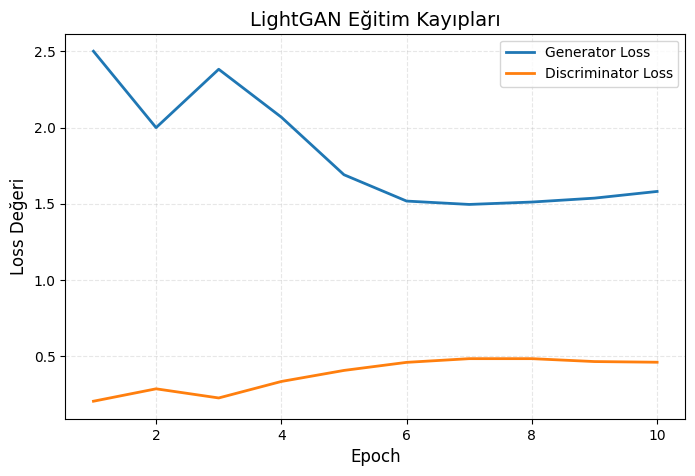

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results_df["Epoch"], results_df["Generator Loss"], label="Generator Loss", linewidth=2)
plt.plot(results_df["Epoch"], results_df["Discriminator Loss"], label="Discriminator Loss", linewidth=2)

plt.title("LightGAN Eğitim Kayıpları", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Değeri", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

LATENT_DIM = 100  # generator'ı tanımlarken kullandığın latent boyutu

def show_generated_images(rows=3, cols=3):
    n = rows * cols

    # 1) Generator girişine uygun boyutta gürültü üret (n, LATENT_DIM)
    noise = np.random.normal(0, 1, (n, LATENT_DIM)).astype("float32")

    # 2) Sahte görselleri üret
    fake_imgs = generator.predict(noise, verbose=0)

    # 3) [-1,1] aralığından [0,1] aralığına ölçekle (tanh kullandığımız için)
    fake_imgs = (fake_imgs + 1.0) / 2.0
    fake_imgs = np.clip(fake_imgs, 0, 1)

    # 4) Görselleri grid halinde çiz
    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(fake_imgs[i])
        plt.axis("off")
    plt.suptitle("LightGAN ile Üretilen Sahte Yüz Örnekleri", fontsize=14)
    plt.tight_layout()
    plt.show()


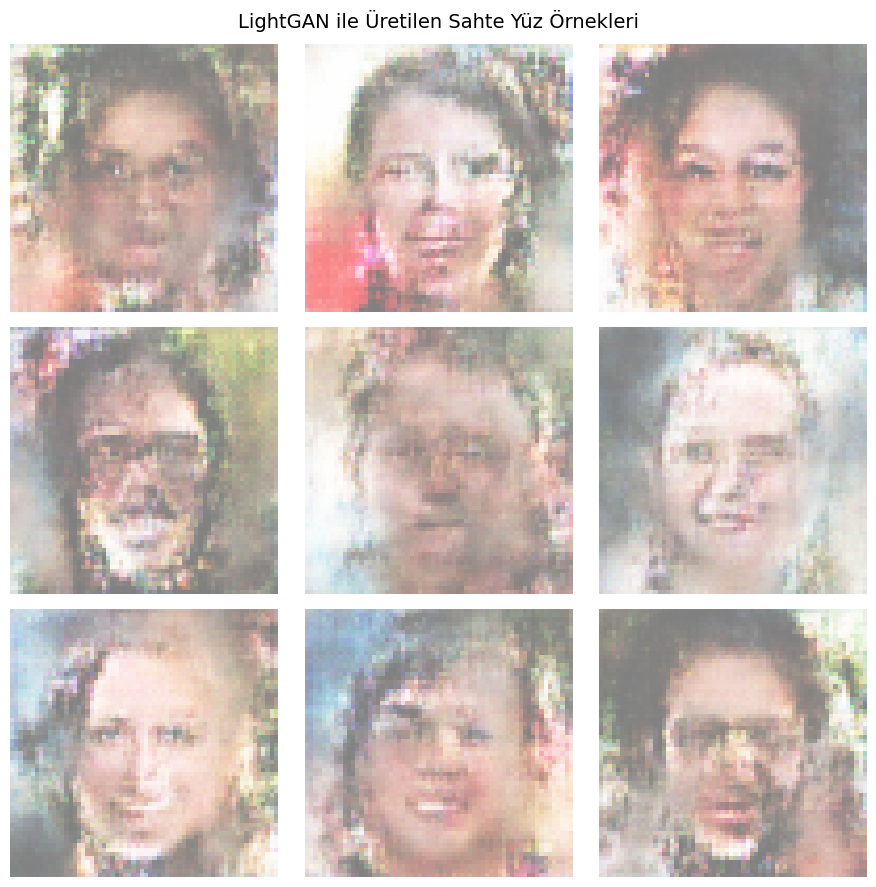

In [ ]:
show_generated_images(3, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os

base_path = "/kaggle/input/deepfake-dataset/real_vs_fake/real-vs-fake"
train_dir = os.path.join(base_path, "train")
valid_dir = os.path.join(base_path, "valid")
test_dir  = os.path.join(base_path, "test")

IMG_SIZE = (64, 64)
BATCH_SIZE = 64

# --- Model A: Ön işleme yok (sadece 0-1 ölçek) ---
datagen_A = ImageDataGenerator(rescale=1./255)

train_A = datagen_A.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_A = datagen_A.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_A = datagen_A.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# --- Model B: Gaussian Blur + 0-1 ölçek (ön işleme var) ---

def blur_preprocess(img):
    # img: 0–255 arası float32/uint8 geliyor
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img

datagen_B = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=blur_preprocess
)

train_B = datagen_B.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_B = datagen_B.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_B = datagen_B.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("✅ Model A/B için generator'lar hazır.")


Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
✅ Model A/B için generator'lar hazır.


In [ ]:
from tensorflow.keras import layers, models

def build_classifier():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

classifier_A = build_classifier()
classifier_B = build_classifier()

classifier_A.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_52 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,142,081 (4.36 MB)

 Trainable params: 1,142,081 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 8  # istersen 10 yapabilirsin

# --- Model A: Ön işleme yok ---
history_A = classifier_A.fit(
    train_A,
    validation_data=val_A,
    epochs=EPOCHS
)

# --- Model B: Ön işleme var (Gaussian blur) ---
history_B = classifier_B.fit(
    train_B,
    validation_data=val_B,
    epochs=EPOCHS
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 290s 179ms/step - accuracy: 0.6370 - loss: 0.6279 - val_accuracy: 0.7558 - val_loss: 0.5046
Epoch 2/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 203s 127ms/step - accuracy: 0.7569 - loss: 0.5087 - val_accuracy: 0.7794 - val_loss: 0.4623
Epoch 3/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 195s 123ms/step - accuracy: 0.7975 - loss: 0.4433 - val_accuracy: 0.8238 - val_loss: 0.3967
Epoch 4/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 194s 122ms/step - accuracy: 0.8312 - loss: 0.3871 - val_accuracy: 0.8533 - val_loss: 0.3417
Epoch 5/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 198s 124ms/step - accuracy: 0.8565 - loss: 0.3409 - val_accuracy: 0.8622 - val_loss: 0.3214
Epoch 6/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 196s 123ms/step - accuracy: 0.8753 - loss: 0.3027 - val_accuracy: 0.8839 - val_loss: 0.2794
Epoch 7/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 193s 121ms/step - accuracy: 0.8868 - loss: 0.2731 - val_accuracy: 0.8971 - val_loss: 0.2537
Epoch 8/8
1595/1595 ━━━━━━━━━━━━━━━━━━━━ 202s 127ms/step - accuracy: 